# ANALISIS DATA COVID-19 COLOMBIA

Xibelly Eliseth Mosquera Escobar

##  Importación de paquetes, librerias y funciones

In [12]:
#intalacion del paquete de analisis de series de tiempo
#!pip install pmdarima

In [1]:
import math
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta
from time import time
from functools import reduce
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import integrate, optimize

import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
#import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score

from sklearn.base import TransformerMixin
#from yellowbrick.classifier import DiscriminationThreshold
import regex as re
import unicodedata
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pmdarima as pm
from pmdarima import metrics

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import regexp_tokenize
from collections import OrderedDict

In [4]:
def ETL (file):
    print('-'*65)
    print('se realiza la carga de la base de datos a un objeto data frame')
    df= file #pd.read_table(file)  #pd.read_pickle(Direccion + nombreBd)
    print("RevisiÃ³n de los datos(NÃºmero de Variables, NÃºmero de registros)")
    print('NÃºmero de variables: {0}'.format(df.shape[1]))
    print('NÃºmero de registros: {0}'.format(df.shape[0]))
    print('-'*65)
    print("revisiÃ³n de las variables que posee la base de datos ")
    print(list(df.columns.values))
    print('-'*65)
    print("Resumen descriptivo de las variables ")
    print(df.describe())
    print('-'*65)
    print('Revision del tipo de variables que contiene la base de datos')
    print(pd.DataFrame(df.dtypes,columns=['Tipo de variable']))
    print('-'*65)
    print("Se realiza una revisiÃ³n si existen datos N/A")
    revisionNull(df)
    print('-'*65)
    print('SelecciÃ³n de variables, en este paso lo que se realiza es la organizaciÃ³n de las variables, para trabajar con las variables categoricas a parte y las numericas ')
    var_categoricas = list(df.select_dtypes(include=['object']).columns)
    var_numericas = list(df.select_dtypes(exclude=['object']).columns)
    print('-'*65)
    print('Reporte de los niveles que puede tener cada una de las variables categoricas')
    for variable in var_categoricas:
        print("\033[1m",variable,":","\033[0;0m",df[variable].unique())
    print(80*'-')
    for variabl in  var_numericas:
        print("--"*30,variabl)
        #plt.cla()
        x = df[variabl].sort_values(ascending = False).reset_index()
        x[variabl].plot()
        #plt.plot(df[variabl].sort_values())    
        plt.show()
        plt.boxplot(x[variabl])
        plt.show()
        plt.close()

    
def revisionNull(df):
    a=df.isnull().sum()
    resulNa=[ re for re in a if re>0 ]
    if resulNa:
        print(resulNa)
        
    else :
        print("No existen valores con NA o null")
                

In [6]:
def procesar_texto(texto): 
    # Convert to lower case and remove punctuation from each word
    sentences = ''.join([word.lower() for word in texto if word.isalpha()])
    return sentences


def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)


##   Lectura de los insumos

La data se puede descargar de:
https://www.ins.gov.co/Noticias/Paginas/Coronavirus.aspx?fbclid=IwAR0yhaEE5fUwdZS72dFSDndHxMtmrQTWlG1b0_Gunv-b_MqH3Wd6cprHdn4

In [7]:
dir_input = r"...\covid-19\Input"

file= os.listdir(dir_input)

print("los archivos suministrados son: ")
print("covid-19 colombia ", file, "\n")

los archivos suministrados son: 
covid-19 colombia  ['Casos1.csv', 'Casos1_06-04-2020.csv'] 



In [8]:
#leyendo los archivos de  "ESTADO" y concatenando en un solo dataframe
archivo = pd.read_csv(os.path.join(dir_input,'Casos1.csv'), sep=',', error_bad_lines=False, encoding='utf-8')

archivo.head()

,ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Departamento o Distrito,Atención**,Edad,Sexo,Tipo*,País de procedencia
0,1,06/03/2020,Bogotá,Bogotá D.C.,Recuperado,19,F,Importado,Italia
1,2,09/03/2020,Buga,Valle del Cauca,Recuperado,34,M,Importado,España
2,3,09/03/2020,Medellín,Antioquia,Recuperado,50,F,Importado,España
3,4,11/03/2020,Medellín,Antioquia,Recuperado,55,M,Relacionado,Colombia
4,5,11/03/2020,Medellín,Antioquia,Recuperado,25,M,Relacionado,Colombia


In [9]:
archivo.dtypes

ID de caso                  int64
Fecha de diagnóstico       object
Ciudad de ubicación        object
Departamento o Distrito    object
Atención**                 object
Edad                        int64
Sexo                       object
Tipo*                      object
País de procedencia        object
dtype: object

In [10]:
# renombrando las columnas
archivo = archivo.rename(columns={'Atención**':'Estado', 'Tipo*':'Tipo', 'ID de caso':'ID', 'Ciudad de ubicación':'Ciudad_destino', 'País de procedencia':'Pais_origen'})
archivo = archivo.drop(['Departamento o Distrito'], axis=1)
archivo = archivo.drop(['Sexo'], axis=1)

In [11]:
# convirtiendo las fechas en formato date-time
archivo["Fecha de diagnóstico"] = archivo["Fecha de diagnóstico"].replace('/','',regex=True).astype(str)
archivo["Fecha de diagnóstico"] = pd.to_datetime(archivo["Fecha de diagnóstico"], format='%d%m%Y')
archivo.head()

,ID,Fecha de diagnóstico,Ciudad_destino,Estado,Edad,Tipo,Pais_origen
0,1,2020-03-06,Bogotá,Recuperado,19,Importado,Italia
1,2,2020-03-09,Buga,Recuperado,34,Importado,España
2,3,2020-03-09,Medellín,Recuperado,50,Importado,España
3,4,2020-03-11,Medellín,Recuperado,55,Relacionado,Colombia
4,5,2020-03-11,Medellín,Recuperado,25,Relacionado,Colombia


In [12]:
# se procesa el texto en los campos de origen - destino
archivo.Ciudad_destino =  archivo.Ciudad_destino.apply(procesar_texto)
archivo.Pais_origen = archivo.Pais_origen.apply(procesar_texto)

archivo.Ciudad_destino = archivo.Ciudad_destino.apply(strip_accents)
archivo.Pais_origen = archivo.Pais_origen.apply(strip_accents)

archivo.Estado = archivo.Estado.apply(procesar_texto)
archivo.Estado = archivo.Estado.apply(strip_accents)

archivo.head()

,ID,Fecha de diagnóstico,Ciudad_destino,Estado,Edad,Tipo,Pais_origen
0,1,2020-03-06,bogota,recuperado,19,Importado,italia
1,2,2020-03-09,buga,recuperado,34,Importado,espana
2,3,2020-03-09,medellin,recuperado,50,Importado,espana
3,4,2020-03-11,medellin,recuperado,55,Relacionado,colombia
4,5,2020-03-11,medellin,recuperado,25,Relacionado,colombia


## Análisis estadístico

Se realiza un análisis estadístico a cada uno de los tipos de insumos suministrados, tal que se pueda identificar que tipo de datos se tienen, la cantidad de datos nulos y/o atípicos.

-----------------------------------------------------------------
se realiza la carga de la base de datos a un objeto data frame
RevisiÃ³n de los datos(NÃºmero de Variables, NÃºmero de registros)
NÃºmero de variables: 7
NÃºmero de registros: 2054
-----------------------------------------------------------------
revisiÃ³n de las variables que posee la base de datos 
['ID', 'Fecha de diagnóstico', 'Ciudad_destino', 'Estado', 'Edad', 'Tipo', 'Pais_origen']
-----------------------------------------------------------------
Resumen descriptivo de las variables 
                ID         Edad
count  2054.000000  2054.000000
mean   1027.500000    43.031646
std     593.083046    17.444686
min       1.000000     0.000000
25%     514.250000    30.000000
50%    1027.500000    41.000000
75%    1540.750000    55.000000
max    2054.000000    97.000000
-----------------------------------------------------------------
Revision del tipo de variables que contiene la base de datos
                     Ti

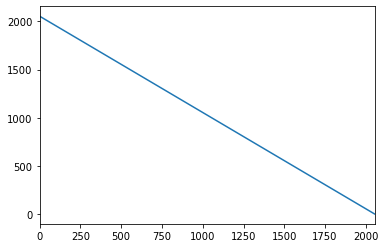

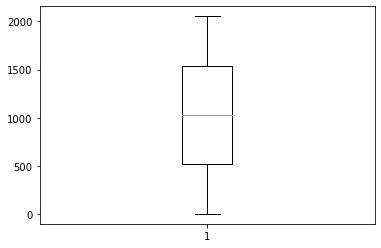

------------------------------------------------------------ Fecha de diagnóstico


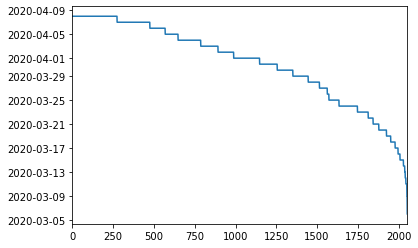

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

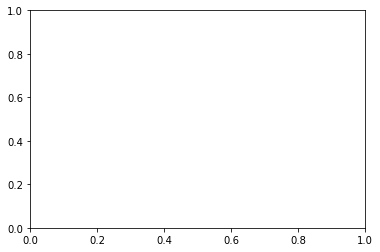

In [13]:
# analisis estadistico 
ETL(archivo)

## Casos confirmados y fallecidos

In [14]:
print("fallecidos Bogotá:",len(archivo[(archivo.Estado == 'fallecido') & (archivo.Ciudad_destino == 'bogota')]))

print("fallecidos Medellín:",len(archivo[(archivo.Estado == 'fallecido') & (archivo.Ciudad_destino == 'medellin')]))

print("fallecidos Cali:",len(archivo[(archivo.Estado == 'fallecido') & (archivo.Ciudad_destino == 'cali')]))

fallecidos Bogotá: 25
fallecidos Medellín: 1
fallecidos Cali: 5


## Supuestos

Se propone filtrar todos aquellos casos que están en el estado: casa, hospital y UCI y se considerarían como casos confirmados del Covid-19, los demás son casos sde muertes confirmadas

In [15]:
contagiados = archivo.copy()

In [16]:
contagiados.Estado.unique()

array(['recuperado', 'casa', 'hospital', 'hospitaluci', 'fallecido'],
      dtype=object)

In [17]:
# casos positivos del Covid-19
contagiados['positivo_covid'] = [1 if i !='fallecido' else 0 for i in contagiados.Estado]

In [18]:
# casos positivos de muertes por Covid-19
contagiados['positivo_fallecido'] = [1 if i =='fallecido' else 0 for i in contagiados.Estado]

In [19]:
# se hace un conteo para tener el total de casos positivos del Covid-19 y de casos de muertes por Covid-19 por echa y region del pais
casos_confirmados = contagiados[contagiados.Estado !='fallecido'].groupby(['Ciudad_destino','Fecha de diagnóstico']).agg({'positivo_covid':'sum'}).reset_index().rename(columns={'positivo_covid':'Casos_confirmados'})
casos_fallecidos = contagiados[contagiados.Estado =='fallecido'].groupby(['Ciudad_destino','Fecha de diagnóstico']).agg({'positivo_fallecido':'sum'}).reset_index().rename(columns={'positivo_fallecido':'Fallecidos'})

In [20]:
# casos en medellin
casos_confirmados[(casos_confirmados.Ciudad_destino == 'medellin')]

,Ciudad_destino,Fecha de diagnóstico,Casos_confirmados
249,medellin,2020-03-09,1
250,medellin,2020-03-11,2
251,medellin,2020-03-14,2
252,medellin,2020-03-15,1
253,medellin,2020-03-19,3
254,medellin,2020-03-20,7
255,medellin,2020-03-21,1
256,medellin,2020-03-22,2
257,medellin,2020-03-23,13
258,medellin,2020-03-25,6


In [217]:
#print(len(contagiados) ,len(casos_confirmados), len(casos_fallecidos))

In [22]:
# casos fallecidos en medellin
casos_fallecidos[(casos_fallecidos.Ciudad_destino == 'medellin')]

,Ciudad_destino,Fecha de diagnóstico,Fallecidos
26,medellin,2020-04-06,1


In [23]:
# unificacion de los casos confirmados de Covid-19 y de muertes
merge1 = pd.merge(casos_confirmados, casos_fallecidos, on=['Ciudad_destino','Fecha de diagnóstico'], how='left')
merge1

,Ciudad_destino,Fecha de diagnóstico,Casos_confirmados,Fallecidos
0,acacias,2020-04-05,1,NaN
1,anapoima,2020-03-20,1,NaN
2,anapoima,2020-03-24,1,NaN
3,andalucia,2020-04-08,1,NaN
4,angostura,2020-04-07,1,NaN
...,...,...,...,...
430,yumbo,2020-03-22,1,NaN
431,yumbo,2020-04-01,4,NaN
432,yumbo,2020-04-06,1,NaN
433,zipaquira,2020-04-05,1,NaN


In [24]:
# replace Nan values by 0
merge1.Fallecidos =  merge1.Fallecidos.replace([np.nan],0)
merge1.Casos_confirmados =  merge1.Casos_confirmados.replace([np.nan],0)

In [25]:
contagiados = pd.merge(contagiados, merge1, on=['Ciudad_destino','Fecha de diagnóstico'], how='left')
contagiados.head()

,ID,Fecha de diagnóstico,Ciudad_destino,Estado,Edad,Tipo,Pais_origen,positivo_covid,positivo_fallecido,Casos_confirmados,Fallecidos
0,1,2020-03-06,bogota,recuperado,19,Importado,italia,1,0,1.0,0.0
1,2,2020-03-09,buga,recuperado,34,Importado,espana,1,0,1.0,0.0
2,3,2020-03-09,medellin,recuperado,50,Importado,espana,1,0,1.0,0.0
3,4,2020-03-11,medellin,recuperado,55,Relacionado,colombia,1,0,2.0,0.0
4,5,2020-03-11,medellin,recuperado,25,Relacionado,colombia,1,0,2.0,0.0


In [26]:
contagiados.isnull().sum()

ID                       0
Fecha de diagnóstico     0
Ciudad_destino           0
Estado                   0
Edad                     0
Tipo                     0
Pais_origen              0
positivo_covid           0
positivo_fallecido       0
Casos_confirmados       14
Fallecidos              14
dtype: int64

In [27]:
# select the interest variables: 
contagiados = contagiados[['ID','Fecha de diagnóstico','Ciudad_destino','Pais_origen','Casos_confirmados','Fallecidos']]

# erase duplicate rows and only left the first one
contagiados_final = contagiados.drop_duplicates(subset=['Fecha de diagnóstico','Ciudad_destino'], keep='last') 

In [28]:
# nos quedamos con la cantidad total de casos confirmados de covid-29 y de muertes por region y fecha
contagiados_final[(contagiados_final.Ciudad_destino == 'medellin') & (contagiados_final['Fecha de diagnóstico'] == '2020-04-08')]

,ID,Fecha de diagnóstico,Ciudad_destino,Pais_origen,Casos_confirmados,Fallecidos
1997,1998,2020-04-08,medellin,estadosunidos,19.0,0.0


In [29]:
display(contagiados_final.describe())

,ID,Casos_confirmados,Fallecidos
count,449.000000,435.000000,435.000000
mean,817.973274,4.595402,0.094253
std,608.067657,12.140004,0.416081
min,1.000000,1.000000,0.000000
25%,288.000000,1.000000,0.000000
50%,700.000000,1.000000,0.000000
75%,1280.000000,3.000000,0.000000
max,2054.000000,131.000000,4.000000


In [30]:
# replace Nan values by 0
contagiados_final.Fallecidos =  contagiados_final.Fallecidos.replace([np.nan],0)
contagiados_final.Casos_confirmados =  contagiados_final.Casos_confirmados.replace([np.nan],0)

In [31]:
contagiados_final.isnull().sum()

ID                      0
Fecha de diagnóstico    0
Ciudad_destino          0
Pais_origen             0
Casos_confirmados       0
Fallecidos              0
dtype: int64

In [32]:
# la venta de tiempo dada es
print("Dates go from day", min(contagiados_final['Fecha de diagnóstico']), "to day", max(contagiados_final['Fecha de diagnóstico']), ", a total of", contagiados_final['Fecha de diagnóstico'].nunique(), "days")

Dates go from day 2020-03-06 00:00:00 to day 2020-04-08 00:00:00 , a total of 31 days


## Análisis exploratorio

A este momento se tiene un dataset con todas las regiones del pais con casos positivos de Covid-19 y muertes para las fechas respectivas de diagnostico ahora veamos el comportamineto en el tiempo

### Numero de casos confirmado y fallecidos en el país

Text(0.5, 0, 'Date')

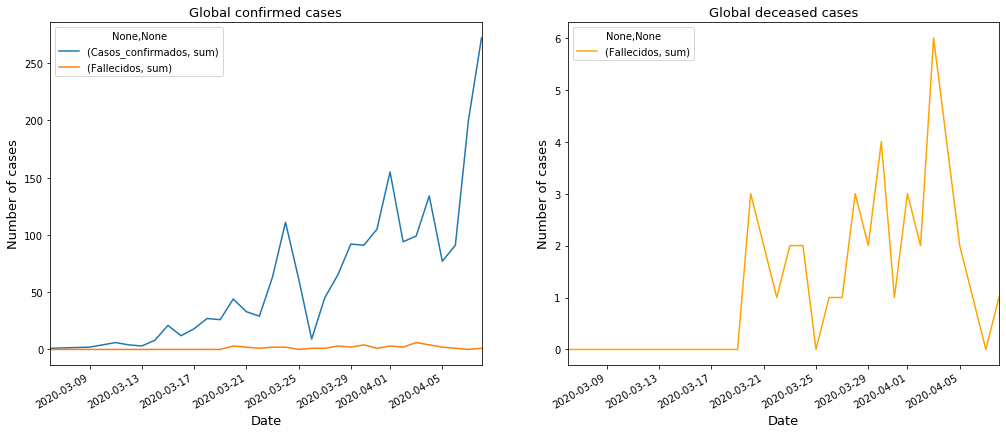

In [33]:
confirmed_total_date = contagiados_final.groupby(['Fecha de diagnóstico']).agg({'Casos_confirmados':['sum']})
fatalities_total_date = contagiados_final.groupby(['Fecha de diagnóstico']).agg({'Fallecidos':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

### Numero de casos confirmado y fallecidos en Medellín

Text(0.5, 0, 'Date')

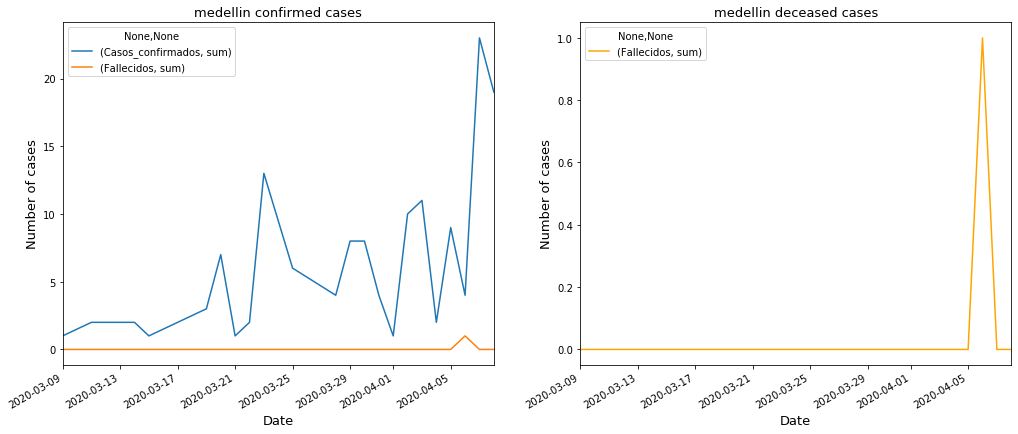

In [35]:
confirmed_total_date = contagiados_final[contagiados_final['Ciudad_destino'] =='medellin'].groupby(['Fecha de diagnóstico']).agg({'Casos_confirmados':['sum']})
fatalities_total_date = contagiados_final[contagiados_final['Ciudad_destino'] =='medellin'].groupby(['Fecha de diagnóstico']).agg({'Fallecidos':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("medellin confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("medellin deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

### Numero de casos confirmado y fallecidos Bogotá

Text(0.5, 0, 'Date')

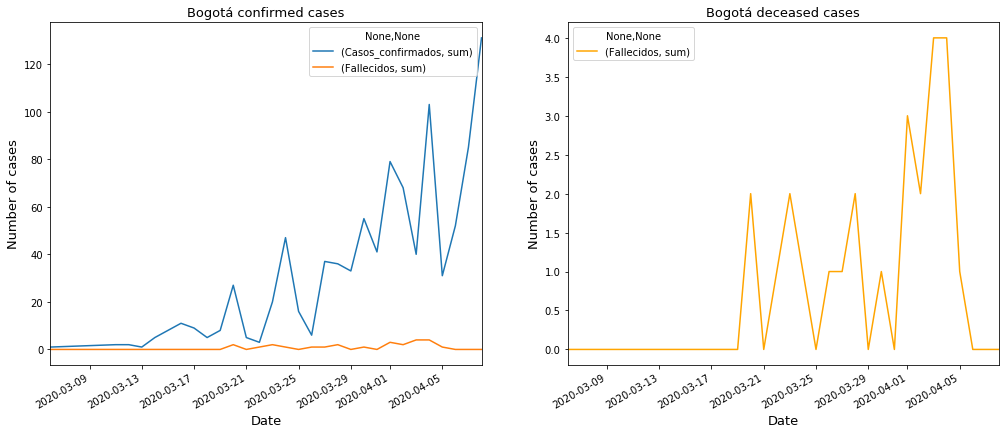

In [36]:
confirmed_total_date = contagiados_final[contagiados_final['Ciudad_destino'] =='bogota'].groupby(['Fecha de diagnóstico']).agg({'Casos_confirmados':['sum']})
fatalities_total_date = contagiados_final[contagiados_final['Ciudad_destino'] =='bogota'].groupby(['Fecha de diagnóstico']).agg({'Fallecidos':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Bogotá confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Bogotá deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

In [37]:
# Create date columns
le = LabelEncoder()
# numero de días transcurridos desde el primer día de contagio
contagiados_final['Day_num'] = le.fit_transform(contagiados_final['Fecha de diagnóstico']) 
# se separa el dia, el mes y  el año de la fecha dada
contagiados_final['Day'] = contagiados_final['Fecha de diagnóstico'].dt.day
contagiados_final['Month'] = contagiados_final['Fecha de diagnóstico'].dt.month
contagiados_final['Year'] = contagiados_final['Fecha de diagnóstico'].dt.year

Con el análisis de los datos en el timepo se puede realizar un ajuste logístico y entrenar un auto-ARIMA para predecir el comprtamiemto a futuro

## Ajuste logistico Bogotá

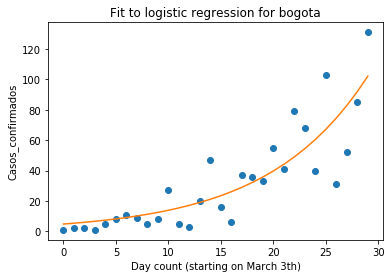

In [53]:
def logistic_function(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

def fit_logistic(all_data, country_name, train_lim, target):
    data_cp = all_data.loc[(all_data['Ciudad_destino']==country_name)]
    y = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    x = list(range(0, len(y)))

    # Initial guess
    p0 = [0,1,1,0]

    (a_, b_, c_, d_), cov = optimize.curve_fit(logistic_function, x, y, bounds=(0, [100000000000., 1000000, 10., 1000000000., ]), p0=p0, maxfev=10**9)
    y_fit = logistic_function(x, a_, b_, c_, d_)
    
    return x, y, y_fit, (a_, b_, c_, d_), cov

def plot_logistic(x, y, y_fit, country_name, target):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y, 'o')
    ax.plot(x, y_fit, '-')
    ax.set_xlabel("Day count (starting on March 3th)")
    ax.set_ylabel(target)
    ax.set_title("Fit to logistic regression for "+ country_name)


# Fit country to logistic curve
city_name = 'bogota'
train_lim = 30
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(contagiados_final, city_name, train_lim, 'Casos_confirmados')
plot_logistic(x, y, y_fit, city_name, 'Casos_confirmados')

## Ajuste logistico Medellín

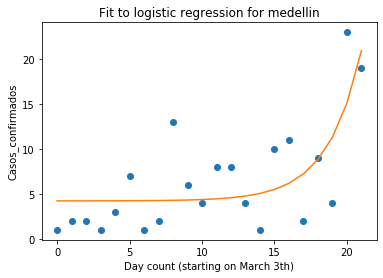

In [55]:
def logistic_function(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

def fit_logistic(all_data, country_name, train_lim, target):
    data_cp = all_data.loc[(all_data['Ciudad_destino']==country_name)]
    y = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    x = list(range(0, len(y)))

    # Initial guess
    p0 = [0,1,1,0]

    (a_, b_, c_, d_), cov = optimize.curve_fit(logistic_function, x, y, bounds=(0, [100000000000., 1000000, 10., 1000000000., ]), p0=p0, maxfev=10**9)
    y_fit = logistic_function(x, a_, b_, c_, d_)
    
    return x, y, y_fit, (a_, b_, c_, d_), cov

def plot_logistic(x, y, y_fit, country_name, target):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y, 'o')
    ax.plot(x, y_fit, '-')
    ax.set_xlabel("Day count (starting on March 3th)")
    ax.set_ylabel(target)
    ax.set_title("Fit to logistic regression for "+ country_name)


# Fit country to logistic curve
city_name = 'medellin'
train_lim = 30
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(contagiados_final, city_name, train_lim, 'Casos_confirmados')
plot_logistic(x, y, y_fit, city_name, 'Casos_confirmados')

## Veamos que hace un modleo como el "Auto-arima"

Para entender a fondo este tipo de modelos de series de tiempo, favor revisar los siguientes links: 

https://otexts.com/fpp2/stationarity.html#fn14

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima

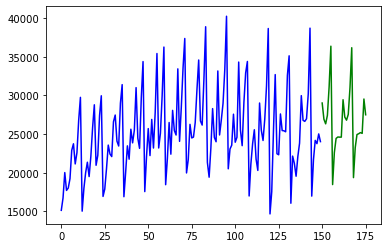

In [3]:
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
y = pm.datasets.load_wineind()
train, test = train_test_split(y, train_size=150)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

Utilicemos ahora este tipo de modelos en nuestra data

## prediccion en series de tiempo ARIMA para Bogotá

In [38]:
# Load/split your data
city_name = 'bogota'
# día de corte para el train/test contado desde el día cero 
train_lim = 26 # corresponde al 04/04/2020
test_lim = train_lim
y = contagiados_final.loc[(contagiados_final['Ciudad_destino']==city_name)]
train = y.loc[(y['Day_num'])<=train_lim, 'Casos_confirmados'].astype(np.int32)
test =  y.loc[(y['Day_num'])>test_lim, 'Casos_confirmados'].astype(np.int32)


# Fit your model
model = pm.auto_arima(train, seasonal=True)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future #

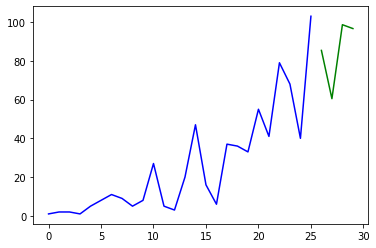

In [39]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0]) #
plt.plot(x[:train_lim], train, c='blue')
plt.plot(x[train_lim:], forecasts, c='green')

plt.show()

In [47]:
y_true =  list(test)
y_pred = list(forecasts)

print(y_true,y_pred)

[31, 52, 85, 131] [85.36660079324058, 60.46254476675352, 98.63523067484945, 96.64295801304976]


### SMAPE error

The Symmetric mean absolute percentage error is an accuracy measure based on percentage (or relative) errors. Where a perfect SMAPE score is 0.0, and a higher score indicates a higher error rate

In [56]:
print("The SMAPE score is:",metrics.smape(y_true, y_pred))

The SMAPE score is: 38.381279289084894


## prediccion en series de tiempo ARIMA para Medellín

In [57]:
# Load/split your data
city_name = 'medellin'
# día de corte para el train/test contado desde el día cero 
train_lim = 26 # corresponde al 04/04/2020
test_lim = train_lim
y = contagiados_final.loc[(contagiados_final['Ciudad_destino']==city_name)]
train = y.loc[(y['Day_num'])<=train_lim, 'Casos_confirmados'].astype(np.int32)
test =  y.loc[(y['Day_num'])>test_lim, 'Casos_confirmados'].astype(np.int32)
#train, test = train_test_split(y, train_size=26)

# Fit your model
model = pm.auto_arima(train, seasonal=True)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future test.shape[0]


In [184]:
y

,ID,Fecha de diagnóstico,Ciudad_destino,Pais_origen,Casos_confirmados,Fallecidos,Day_num,Day,Month,Year
2,3,2020-03-09,medellin,espana,1.0,0.0,1,9,3,2020
4,5,2020-03-11,medellin,colombia,2.0,0.0,2,11,3,2020
20,21,2020-03-14,medellin,colombia,2.0,0.0,5,14,3,2020
31,32,2020-03-15,medellin,espana,1.0,0.0,6,15,3,2020
107,108,2020-03-19,medellin,espana,3.0,0.0,10,19,3,2020
144,145,2020-03-20,medellin,colombia,7.0,0.0,11,20,3,2020
197,198,2020-03-21,medellin,espana,1.0,0.0,12,21,3,2020
237,238,2020-03-22,medellin,espana,2.0,0.0,13,22,3,2020
295,296,2020-03-23,medellin,colombia,13.0,0.0,14,23,3,2020
465,466,2020-03-25,medellin,colombia,6.0,0.0,16,25,3,2020


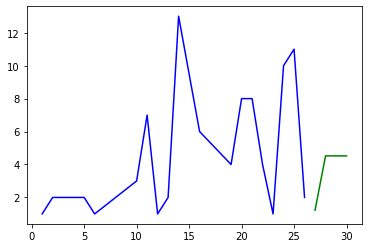

In [58]:
x = y.Day_num
plt.plot(x[x <= train_lim], train, c='blue')
plt.plot(x[x > train_lim], forecasts, c='green')

plt.show()

In [59]:
y_true =  list(test)
y_pred = list(forecasts)

print(y_true,y_pred)

[9, 4, 23, 19] [1.2223251348230049, 4.522395020027719, 4.522395020027719, 4.522395020027719]


In [60]:
print("The SMAPE score is:",metrics.smape(y_true, y_pred))

The SMAPE score is: 105.44982517795472


## ARIMA PREDICTIONS  VERSION COMPLETE

In [149]:
# Define a general function to run ARIMA regression
def arima_cp(all_data, city_name, target, train_lim, test_lim):
    
    #Select data for the Country/Region, splitting train/test days
    data_cp = all_data.loc[(all_data['Ciudad_destino']==city_name)]
    data_cp_train = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    data_cp_test = data_cp.loc[(data_cp['Day_num'])>test_lim, target].astype(np.int32)


    # Set the range of parameters to use
    stepwise_model = pm.auto_arima(data_cp[target], start_p=1, start_q=1, max_p=30, max_q=30, 
                                start_P=0, seasonal=False, d=2, trace=False, error_action='ignore', stepwise=True)

    # Train and predict
    stepwise_model.fit(data_cp_train, start_ar_lags=2*max(30, 30))
    forecast = stepwise_model.predict(n_periods=15)
    return forecast, data_cp_train


# Plot the actual values vs predictions
def plot_arima_country(all_data, train, forecast, city_name, valid_num, target):
    df_train = train 
    df_fcst = np.append(df_train[:valid_num], forecast)
    dates = list(range(0,len(df_fcst))) 
    print(len(dates))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
    ax1.plot(dates, df_fcst, color='orange')

    ax1.axvline(valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.set_title("Actual ConfirmedCases vs predictions based on ARIMA for "+city_name)
    ax1.legend(['Predicted cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on March 3th")
    ax1.set_ylabel("ConfirmedCases")
    
 # Plot the actual values
def plot_actaula_cases(all_data, train, city_name):
    df_train = train #.loc[(train['Ciudad_destino']==city_name), target]
    #df_fcst = np.append(df_train[:valid_num], forecast)
    dates = list(range(0,len(df_train)))  #np.arange(all_data.shape[0]) #
    #print(len(dates))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
  
    ax1.plot(dates, df_train)
    ax1.set_title("Actual ConfirmedCases for "+city_name)
    ax1.legend(['Actual ConfirmedCases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on March 3th")
    ax1.set_ylabel("ConfirmedCases")
       

41


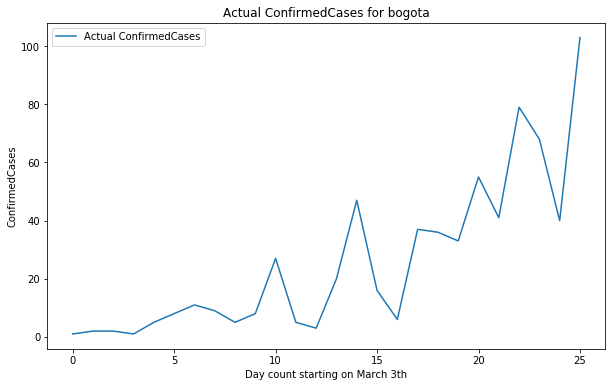

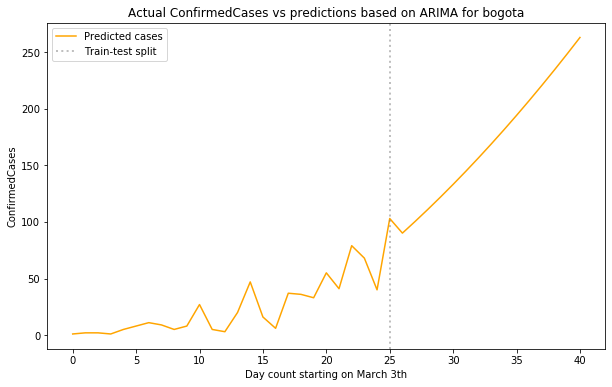

In [150]:
city_name = 'bogota'
train_lim = 26 # corresponde al 04/04/2020
test_lim = train_lim
valid_lim = 19 # needs to be changed as more days of training data are included
valid_num= 26#valid_lim-train_lim 

forecast, train = arima_cp(contagiados_final, city_name, 'Casos_confirmados', train_lim, test_lim)

plot_actaula_cases(contagiados_final, train, city_name)

plot_arima_country(contagiados_final, train, forecast, city_name, valid_num, 'Casos_confirmados')

## ARIMA PREDICTIONS FOR COLOMBIA - Confirmed cases and death cases

In [183]:
# Define a general function to run ARIMA regression
def arima_colombia(all_data, target, train_lim, test_lim):
    
    confirmed_total_date = all_data.groupby(['Day_num']).agg({'Casos_confirmados':'sum'}).reset_index()
    
    data_cp_train = confirmed_total_date.loc[(confirmed_total_date['Day_num'])<=train_lim, target].astype(np.int32)
    data_cp_test = confirmed_total_date.loc[(confirmed_total_date['Day_num'])>test_lim, target].astype(np.int32)

    # Set the range of parameters to use
    stepwise_model = pm.auto_arima(confirmed_total_date[target], start_p=1, start_q=1, max_p=30, max_q=30, 
                                start_P=0, seasonal=False, d=2, trace=False, error_action='ignore', stepwise=True)

    # Train and predict
    stepwise_model.fit(data_cp_train, start_ar_lags=2*max(30, 30))
    forecast = stepwise_model.predict(n_periods=15)
    return forecast, data_cp_train, data_cp_test



In [192]:
# Plot the actual values vs predictions
def plot_arima_colombia(all_data, train, forecast, valid_num, target):
    df_train = train 
    df_fcst = np.append(df_train[:valid_num], forecast)
    dates = list(range(0,len(df_fcst))) 
    print(len(dates))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
    ax1.plot(dates, df_fcst, color='red')

    ax1.axvline(valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.set_title("Actual ConfirmedCases vs predictions based on ARIMA for Colombia")
    ax1.legend(['Predicted cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on March 3th")
    ax1.set_ylabel("ConfirmedCases")

41


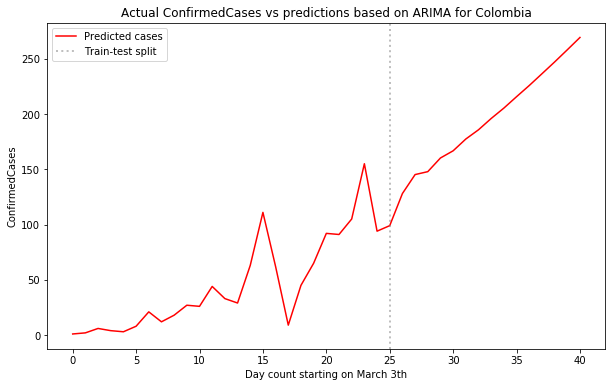

In [193]:
forecast, train, test = arima_colombia(contagiados_final, 'Casos_confirmados', 26, 26)

plot_arima_colombia(contagiados_final, train, forecast, 26, 'Casos_confirmados')

## Compute the SMAPE error for Colombia

In [188]:
y_true =  list(test)
y_pred = list(forecast[:4]) # se toman los primeros 4 días de prediccion

print(y_true,y_pred)

[77, 91, 200, 272] [128.03287085019514, 145.1923203883819, 147.837007790144, 160.21155799618558]


In [189]:
print("The SMAPE score is:",metrics.smape(y_true, y_pred))

The SMAPE score is: 44.34745987737904


In [204]:
# Define a general function to run ARIMA regression
def arima_colombia_fallecidos(all_data, target, train_lim, test_lim):
    
    confirmed_total_death_date = all_data.groupby(['Day_num']).agg({'Fallecidos':'sum'}).reset_index()
    
    train = confirmed_total_death_date.loc[(confirmed_total_death_date['Day_num'])<=train_lim, target].astype(np.int32)
    test = confirmed_total_death_date.loc[(confirmed_total_death_date['Day_num'])>test_lim, target].astype(np.int32)

    # Set the range of parameters to use
    stepwise_model = pm.auto_arima(confirmed_total_death_date[target], start_p=1, start_q=1, max_p=30, max_q=30, 
                                start_P=0, seasonal=False, d=2, trace=False, error_action='ignore', stepwise=True)

    # Train and predict
    stepwise_model.fit(train, start_ar_lags=2*max(30, 30))
    forecast = stepwise_model.predict(n_periods=15)
    return forecast, train, test


In [210]:
# Plot the actual values vs predictions
def plot_arima_colombia_fallecidos(all_data, train, forecast, valid_num, target):
    df_train = train 
    df_fcst = np.append(df_train[:valid_num], forecast)
    dates = list(range(0,len(df_fcst))) 
    print(len(dates))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
    ax1.plot(dates, df_fcst, color='green')

    ax1.axvline(valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.set_title("Actual ConfirmedDeathCases vs predictions based on ARIMA for Colombia")
    ax1.legend(['Predicted cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count starting on March 3th")
    ax1.set_ylabel("DeathCases")

41


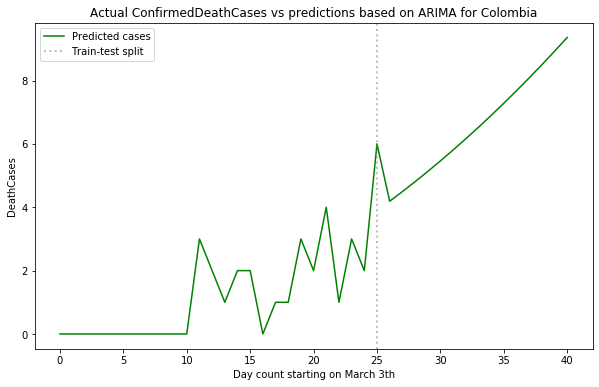

In [212]:
forecast_death, train_death, test_death = arima_colombia_fallecidos(contagiados_final, 'Fallecidos', 26, 26)

plot_arima_colombia_fallecidos(contagiados_final, train_death, forecast_death, 26, 'Fallecidos')

## Compute the SMAPE error for Colombia death cases

In [213]:
y_death_true =  list(test_death)
y_detah_pred = list(forecast_death[:4]) # se toman los primeros 4 días de prediccion

print(y_death_true,y_detah_pred)

[2, 1, 0, 1] [4.189974541063691, 4.492746569834418, 4.805750145117399, 5.128985266912633]


In [214]:
print("The SMAPE score is:",metrics.smape(y_death_true, y_detah_pred))

The SMAPE score is: 133.16794670926245


In [ ]:
# casos_fallecidos = pd.DataFrame(contagiados.groupby(['Ciudad_destino','Fecha de diagnóstico']).agg({'positivo_fallecido':'sum'})).reset_index().rename(columns={'positivo_fallecido':'Fallecidos'})

# contagiados = pd.merge(contagiados, casos_fallecidos, on=['Ciudad_destino','Fecha de diagnóstico'], how='left')
# contagiados.head()

# casos_confirmados = pd.DataFrame(contagiados.groupby(['Ciudad_destino','Fecha de diagnóstico']).agg({'positivo_covid':'sum'})).reset_index().rename(columns={'positivo_covid':'Casos_confirmados'})

# contagiados = pd.merge(contagiados, casos_confirmados, on=['Ciudad_destino','Fecha de diagnóstico'], how='left')
# contagiados.head()